## Init

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/mount', force_remount=True)
    %cd mount/MyDrive/MachineLearningProjects/ShapeCorrection/notebooks
except ModuleNotFoundError: ...

In [2]:
import os, sys
sys.path.append("..")

In [3]:
import keras
from keras.layers import *
import tensorflow as tf

import numpy as np
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt

import utils

2023-05-03 13:32:07.517490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 13:32:07.668234: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 13:32:07.670956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 13:32:07.670970: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Configuration

In [4]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
MODLDIR = BASEDIR / "models"
DATASET = DESTDIR / "words.npz"
model_name = "proto.h5"

In [5]:
image_width = 128
image_height = 32
batch_size = 64

max_len = 21
padding_token = 99
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
characters = [
	'!', '"', '#', '&', "'", '(', ')', '*', '+', ',',
	'-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
	'7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D',
	'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
	'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
	'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
	'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
	's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


2023-05-03 13:32:10.566631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-03 13:32:10.566653: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 13:32:10.566671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-05-03 13:32:10.567744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [14]:
model = utils.load(MODLDIR / model_name)
char_to_num = StringLookup(vocabulary=list(model.meta), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)
print(model.meta)

{'name': 'model', 'epochs': 50, 'characters': '!"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz', 'padding': 99, 'maxlen': 21, 'frozen': True}


## Test predictions

In [9]:
from google.colab import files

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :model.meta.maxlen]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = pad_resize_transpose(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def upload_and_predict():
    img = files.upload()
    name = list(img.keys())[0]
    x = preprocess_image(name)

    preds = model.predict(tf.reshape([x], (1, 128, 32, 1)))
    label = decode_batch_predictions(preds)

    img = tf.io.read_file(name)
    img = tf.image.decode_png(img, 1)
    plt.imshow(img, cmap="gray")
    plt.title(label[0])


In [10]:
upload_and_predict()

NameError: name 'files' is not defined

Saving grayscale.png to grayscale.png
1/1 [==============================] - 0s 34ms/step


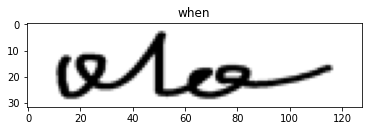

In [ ]:
upload_and_predict()

Saving well.png to well.png
1/1 [==============================] - 0s 40ms/step


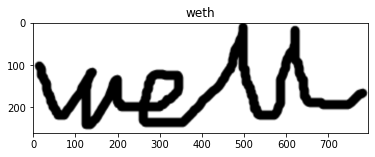

In [ ]:
upload_and_predict()

Saving well2.png to well2.png
1/1 [==============================] - 0s 35ms/step


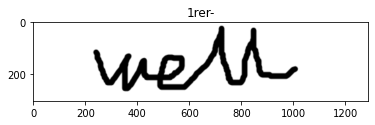

In [ ]:
upload_and_predict()

Saving 8.png to 8.png
1/1 [==============================] - 0s 32ms/step


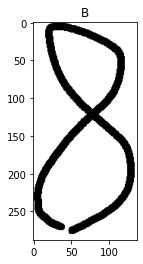

In [ ]:
upload_and_predict()

Saving How.png to How.png
1/1 [==============================] - 0s 64ms/step


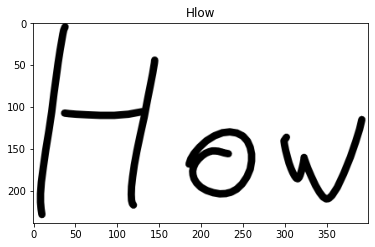

In [ ]:
upload_and_predict()

Saving L.png to L.png
1/1 [==============================] - 0s 38ms/step


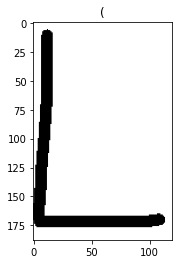

In [ ]:
upload_and_predict()

Saving a.png to a.png
1/1 [==============================] - 0s 32ms/step


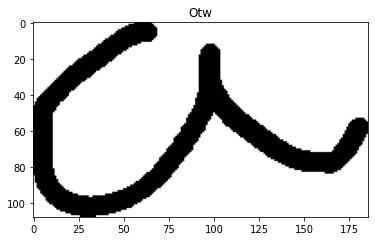

In [ ]:
upload_and_predict()

Saving a2.png to a2.png
1/1 [==============================] - 0s 38ms/step


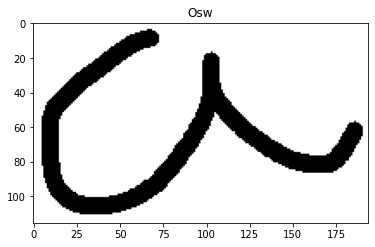

In [ ]:
upload_and_predict()